### Q-Learning Mountain-Car

A shaping rewards problem <br>

For Q-Learning must be discretize in bins. Remember observation space has 2 positions (x, v)


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hiperparameters

n_bins = [20, 20]
alpha = 0.1
gamma = 0.99
epsilon = 0.9
epsilon_decay = 0.99
min_epsilon = 0.1
episodes = 100000
ROLLING_WINDOW = 20


In [3]:
# Support Functions

env = gym.make("MountainCar-v0")

# Create bins for discretization
def create_bins():
    pos_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_bins[0] - 1)
    vel_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], n_bins[1] - 1)
    return [pos_bins, vel_bins]

bins = create_bins()

def discretize(obs):
    return tuple(np.digitize(obs[i], bins[i]) for i in range(len(obs)))

In [4]:
# Training

Q = np.zeros(n_bins + [env.action_space.n])

shaped_rewards_history = []
true_rewards_history = []
rolling_avg_True = []
rolling_avg_shaped = []

for ep in range(episodes):
    obs, _ = env.reset()
    state = discretize(obs)

    done = False
    ep_shaped_reward = 0
    ep_true_reward = 0

    step = 0
    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, done, _, _ = env.step(action)

###### SHAPING REWARDS  #####
        
        shaped_reward = reward
        if done and step < 200:
          # If episode is ended the we have won the game. So, give some large positive reward
            shaped_reward = 250 + shaped_reward

        # Velocity is important, we give positive reward for velocity (is the sign correct?)
        velocity = next_obs[1]
        shaped_reward = shaped_reward + 10 * abs(velocity)
        
###### END SHAPING REWARDS  #####

        ep_shaped_reward += shaped_reward
        ep_true_reward += reward

        next_state = discretize(next_obs)

        # Q-learning update with shaped reward
        max_next_q = np.max(Q[next_state])
        current_q = Q[state + (action,)]
        Q[state + (action,)] = current_q + alpha * (shaped_reward + gamma * max_next_q - current_q)

        state = next_state
        step = step + 1
        

    ep = ep + 1
    shaped_rewards_history.append(ep_shaped_reward)
    true_rewards_history.append(ep_true_reward)
    rolling_avg_shaped.append(np.mean(shaped_rewards_history[-ROLLING_WINDOW:]))   
    rolling_avg_True.append(np.mean(true_rewards_history[-ROLLING_WINDOW:]))     
    
    # Print progress
    if (ep + 1) % 100 == 0:
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        avg_shaped = np.mean(shaped_rewards_history[-100:])
        avg_true = np.mean(true_rewards_history[-100:])
        print(f"Episode {ep + 1} | Avg Shaped: {avg_shaped:.2f} | Avg True: {avg_true:.2f} | Epsilon: {epsilon:.3f}")

        if avg_shaped > 0:
            print(f"✅ Solved with true avg reward {avg_true:.2f} at episode {ep + 1}")
            break


Episode 100 | Avg Shaped: -3498.04 | Avg True: -4645.81 | Epsilon: 0.891
Episode 200 | Avg Shaped: -2482.24 | Avg True: -3331.44 | Epsilon: 0.882
Episode 300 | Avg Shaped: -1776.20 | Avg True: -2359.98 | Epsilon: 0.873
Episode 400 | Avg Shaped: -1728.12 | Avg True: -2312.38 | Epsilon: 0.865
Episode 500 | Avg Shaped: -1629.82 | Avg True: -2191.41 | Epsilon: 0.856
Episode 600 | Avg Shaped: -1481.49 | Avg True: -1991.27 | Epsilon: 0.847
Episode 700 | Avg Shaped: -1342.30 | Avg True: -1785.70 | Epsilon: 0.839
Episode 800 | Avg Shaped: -1265.07 | Avg True: -1690.60 | Epsilon: 0.830
Episode 900 | Avg Shaped: -1083.66 | Avg True: -1435.48 | Epsilon: 0.822
Episode 1000 | Avg Shaped: -963.03 | Avg True: -1272.90 | Epsilon: 0.814
Episode 1100 | Avg Shaped: -882.57 | Avg True: -1157.02 | Epsilon: 0.806
Episode 1200 | Avg Shaped: -833.39 | Avg True: -1096.93 | Epsilon: 0.798
Episode 1300 | Avg Shaped: -906.29 | Avg True: -1196.08 | Epsilon: 0.790
Episode 1400 | Avg Shaped: -742.83 | Avg True: -982

Episode 11500 | Avg Shaped: -32.25 | Avg True: -219.31 | Epsilon: 0.283
Episode 11600 | Avg Shaped: -139.07 | Avg True: -269.55 | Epsilon: 0.280
Episode 11700 | Avg Shaped: -220.23 | Avg True: -342.45 | Epsilon: 0.278
Episode 11800 | Avg Shaped: -203.15 | Avg True: -319.91 | Epsilon: 0.275
Episode 11900 | Avg Shaped: -98.22 | Avg True: -241.54 | Epsilon: 0.272
Episode 12000 | Avg Shaped: -151.15 | Avg True: -259.47 | Epsilon: 0.269
Episode 12100 | Avg Shaped: -80.85 | Avg True: -217.52 | Epsilon: 0.267
Episode 12200 | Avg Shaped: 12.97 | Avg True: -209.23 | Epsilon: 0.264
✅ Solved with true avg reward -209.23 at episode 12200


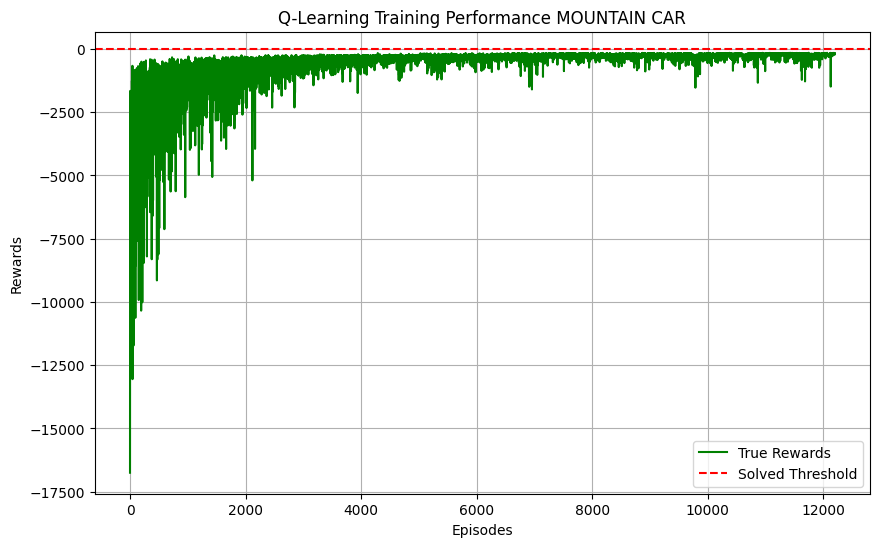

In [5]:
# Plot rewards and shaped rewards
solved_threshold = 0

plt.figure(figsize=(10, 6))
plt.plot(true_rewards_history, label='True Rewards', color='green')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('Q-Learning Training Performance MOUNTAIN CAR')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

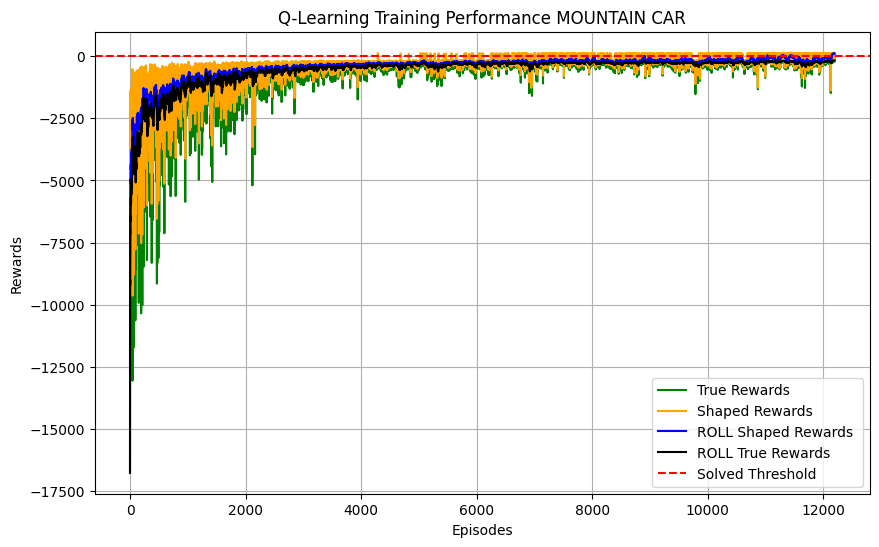

In [6]:
# Plot rewards and shaped rewards
solved_threshold = 0

plt.figure(figsize=(10, 6))
plt.plot(true_rewards_history, label='True Rewards', color='green')
plt.plot(shaped_rewards_history, label='Shaped Rewards ', color='orange')
plt.plot(rolling_avg_shaped, label='ROLL Shaped Rewards ', color='blue')
plt.plot(rolling_avg_True, label='ROLL True Rewards ', color='black')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('Q-Learning Training Performance MOUNTAIN CAR')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

In [7]:
# Test the learned policy
env = gym.make("MountainCar-v0", render_mode='human')
obs, _ = env.reset()
state = discretize(obs)
done = False
total_reward = 0

while not done:
    action = np.argmax(Q[state])
    obs, reward, terminated, truncated, _ = env.step(action)
    state = discretize(obs)
    done = terminated or truncated
    total_reward += reward
    env.render()

print(f"\nTotal reward: {total_reward}")


Total reward: -189.0
